In [1]:
from glob import glob
import uproot as ur
import numpy as np
import json, os
import os.path as osp
from tqdm.auto import tqdm
from typing import Optional
from json import load
from phc import module_reload, plot_hist
module_reload('zhh')
from zhh import parse_sample_path, get_preselection_passes, ProcessIndex, \
    get_chunks_factual, EventCategories, sample_weight, presel_stack, \
    parse_json, get_pol_key, get_final_state_counts, fig_ild_style, \
    get_process_normalization, plot_preselection_by_event_category, \
    plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, \
    calc_preselection_by_processes, zhh_cuts, apply_cuts, \
    Cut, WindowCut, LessThanEqualCut, GreaterThanEqualCut, EqualCut
from zhh.plot.plot_preselection import plot_preselection_by_calc_dict
version = 'v1'

REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH' if os.name != 'nt' else 'C:/DevRepositories/ZHH'
DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh' if os.name != 'nt' else f'{REPO_ROOT}/DATA_ROOT'
INDEX_DIR = f'{DATA_ROOT}/CreateRawIndex/v1'

processes = np.load(f"{INDEX_DIR}/processes.npy")
samples = np.load(f"{INDEX_DIR}/samples.npy")
chunks = np.load(f'{DATA_ROOT}/CreatePreselectionChunks/v1/chunks.npy') if os.name != 'nt' else np.load(f'{DATA_ROOT}/chunks_f.npy')

Preselection Detailed

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

mode = 'prod'
save = False

if mode == 'prod':
    DATA_R = f'{DATA_ROOT}/PreselectionFinal/{version}'
    branches = [14336]
elif mode == 'debug':
    DATA_R = f'{REPO_ROOT}/output'
    branches = ['zhh']

In [3]:
module_reload('zhh')
from zhh import presel_stack
from typing import List, Optional, Generator

def iterate_chunks(files:List[str], mmap:bool=False)->Generator:
    for file in files:
        yield np.load(file, mmap_mode=(None if mmap else 'r'))

def join_chunks(size:int, files:List[str]):    
    result = None
    pointer = 0

    for file in tqdm(files):
        part = np.load(file)
        if result is None:
            result = np.zeros(size, dtype=part.dtype)
            
        result[pointer:(pointer+len(part))] = part
        pointer += len(part)
    
    return result

if mode == 'prod' or mode == 'prod-debug':
    if os.name != 'nt':
        chunks_f = get_chunks_factual(f'{DATA_ROOT}/PreselectionFinal/{version}', chunks_in=chunks)
    else:
        chunks_f = chunks

if mode == 'prod-debug':
    # create PreselectionSummary results here
    presel_results = presel_stack(f'{DATA_ROOT}/PreselectionFinal/{version}', processes, chunks_f, [0,1])#chunks['branch'])
elif mode == 'prod':
    # use PreselectionSummary results
    size = chunks_f['chunk_size_factual'].sum()
    
    presel_results = join_chunks(size, glob(f'{DATA_ROOT}/PreselectionSummary/v1/[0-9]*_Presel.npy'))
    presel_fsc = join_chunks(size, glob(f'{DATA_ROOT}/PreselectionSummary/v1/[0-9]*_FinalStates.npy'))
    
elif mode == 'debug':
    branch = 'zhh'
    meta = parse_json(f'{REPO_ROOT}/output/{branch}_FinalStateMeta.json')
    
    chunks_f_deb = np.zeros(1, dtype=[('branch', f'<U{len(branch)}'), ('proc_pol', '<U32'), ('chunk_size_factual', 'I')])
    chunks_f_deb['branch'] = 'zhh'
    chunks_f_deb['proc_pol'] = f"{meta['processName']}_{get_pol_key(meta['polElectron'], meta['polPositron'])}"
    chunks_f_deb['chunk_size_factual'] = meta['nEvtSum']
    
    presel_results = presel_stack(f'{REPO_ROOT}/output', processes, chunks_f_deb, [branch], kinematics=True)
elif mode == 'load':
    presel_results = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_results.npy')

if mode != 'load':
    # Calculate weights
    pids = np.unique(presel_results['pid'])
    weights = np.zeros(len(pids), dtype=[('pid', 'H'), ('weight', 'f')])
    weights['pid'] = pids

    for pid in tqdm(pids):
        process = processes[processes['pid'] == pid][0]
        pol_em, pol_ep = process['pol_e'], process['pol_p']
        cross_sec = process['cross_sec']
        
        n_gen = np.sum(presel_results['pid'] == pid)
        
        weights['weight'][weights['pid'] == pid] = sample_weight(cross_sec, (pol_em, pol_ep), n_gen)
else:
    weights = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_weights.npy')
    chunks_f = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy')
    
if save == True:
    np.save(f'{DATA_ROOT}/presel_results.npy', presel_results)
    np.save(f'{DATA_ROOT}/presel_weights.npy', weights)
    np.save(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy', chunks_f)
    
event_category_bck = np.copy(presel_results['event_category'])

  0%|          | 0/18 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [4]:
print(f'{len(presel_results)} events using {presel_results.nbytes/1024/1024:.2f} MB')

44042324 events using 5376.26 MB


In [5]:
print(f'Using    : {len(presel_results)/1e6:.2f}M events')
print(f'Available: {samples["n_events"].sum()/1e6:.2f}M events')

Using    : 44.04M events
Available: 58.74M events


In [14]:
a = presel_results[presel_results['event_category'] == EventCategories.llHH]
b = a[a['Nb'] == 4]

print(len(a), len(b))

4668 1577


In [6]:
pn = get_process_normalization(processes, samples)
np.sum(pn['n_events_expected'][np.isin(pn['process'], ['e1e1hh', 'e2e2hh', 'e3e3hh'])])

41.167603

In [14]:
def cross_section_by_category(
    data:np.ndarray,
    event_category:int,
    processes:np.ndarray,
    weights:np.ndarray):
    
    event_mask = data['event_category'] == event_category
    subset = data[mask]
    
    s_pids = np.unique(subset['pid'])    
    s_cross_secs = processes['cross_sec'][s_pids]
    s_weights = weights['weight'][s_pids]
    
    s_counts = np.zeros(len(s_pids), dtype=int)
    s_branchings = np.zeros(len(s_pids), dtype=float) # branching into desired final state
    s_uncertainties = np.zeros(len(s_pids), dtype=float) # scales with 1/sqrt(n) with n weighted
    
    for i, pid in enumerate(pids):
        s_counts[i] = np.sum(subset['pid'] == pid)
        
        mask_1 = data['event_category'] == event_category
        mask_2 = mask_1 & (data['pid'] == pid)
        
        s_branchings[i] = ().sum()

In [ ]:
from typing import List, Union, Iterable
from matplotlib.figure import Figure

def plot_cut_efficiency(presel_results:np.ndarray, masks:List[np.ndarray],
                        processes:np.ndarray, weights:np.ndarray,
                        signal_categories:List[int],
                        hypothesis:str, quantity:str, xunit:Optional[str]='GeV',
                        event_categories:Optional[List[int]]=None,
                        additional_event_categories:int=2,
                        with_sbr:bool=True, previous_mask:Optional[np.ndarray]=None,
                        xlim:Optional[tuple]=None, yscale:str='log', nbins:Union[int,Iterable[int]]=100,
                        ild_style_kwargs:dict={}, xlabel:Optional[str]=None)->List[Figure]:
    all_figs = []
    subsets = []
    for mask in masks:
        subsets.append(presel_results[mask])
    
    subset_pre = subsets[0]
    subset_end = subsets[-1]

    mask_pre_cat = np.isin(subset_pre['event_category'], signal_categories)
    mask_end_cat = np.isin(subset_end['event_category'], signal_categories)

    weights_pre  = weights['weight'][subset_pre[mask_pre_cat]['pid']]
    weights_post = weights['weight'][subset_end[mask_end_cat]['pid']]

    signal_eff = np.sum(weights_post)/np.sum(weights_pre)
    
    # Calculate relative signal efficiency
    signal_eff_relative = 0.
    if previous_mask is not None:
        subset_prev = presel_results[previous_mask]
        weights_prev  = weights['weight'][subset_prev[np.isin(subset_prev['event_category'], signal_categories)]['pid']]
        
        signal_eff_relative = np.sum(weights_post)/np.sum(weights_pre)
    
    if with_sbr:
        SBR_pre  = np.sum(weights_pre)/weights['weight'][subset_pre[~mask_pre_cat]['pid']].sum()
        SBR_end = np.sum(weights_post)/weights['weight'][subset_end[~mask_end_cat]['pid']].sum()
    
    for i, subset in enumerate([subset_pre, subset_end]):
        with_cuts = i > 0
        if with_cuts:
            title_postfix = r' $\bf{with}$ cuts @ ' + rf'${signal_eff*100:0.1f}{{%}}_{{abs}}$ eff.'
        else:
            title_postfix = r' $\bf{without}$ cuts'
        
        if with_sbr:
            title_postfix += rf'; SBR={(SBR_end if with_cuts else SBR_pre):.2E}'
        
        figs = plot_preselection_by_event_categories(subset, processes, weights,
                                                     hypothesis=hypothesis, quantity=quantity,
                                                     categories_selected=event_categories,
                                                     categories_additional=additional_event_categories,
                                         plot_flat=False, unit=xunit, xlim=(xlim[i] if isinstance(xlim, list) else xlim),
                                        xlabel=quantity if xlabel is None else xlabel, yscale=yscale,
                                        ild_style_kwargs={
                                            'ild_offset_x': 0.55,
                                            'title_postfix': title_postfix
                                        } | ild_style_kwargs, nbins=(nbins[i] if isinstance(nbins, list) else nbins))
        for fig in figs:
            all_figs.append(fig)
                
    return all_figs

In [14]:
module_reload('phc')
module_reload('zhh')
from matplotlib.ticker import MultipleLocator
from phc import plot_hist, export_figures
from zhh import fig_ild_style, plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, plot_preselection_by_calc_dict, \
    Cut, WindowCut, LessThanEqualCut, GreaterThanEqualCut, EqualCut

In [26]:
def annotate_cut(ax, cut:Cut):
    if isinstance(cut, WindowCut):
        ax.axvspan(cut.lower, cut.upper, .97, alpha=0.7, color='r', hatch='*')
        ax.axvline(x=cut.lower, linewidth=1.5, color='r', alpha=0.7)
        ax.axvline(x=cut.upper, linewidth=1.5, color='r', alpha=0.7)
        
    else:
        if isinstance(cut, GreaterThanEqualCut) or isinstance(cut, LessThanEqualCut):
            value = cut.lower if isinstance(cut, GreaterThanEqualCut) else cut.upper
        elif isinstance(cut, EqualCut):
            value = cut.value
        else:
            raise ValueError(f'Unknown cut type {type(cut)}')
        
        if isinstance(value, int):
            ax.axvspan(value - .5, value + .5, .97, alpha=0.7, color='r', hatch='*')
        else:
            ax.axvline(x=value, linewidth=1.5, color='r', alpha=0.7)
            
def plot_total_efficiency(counts_first:dict, counts_last:dict, hypothesis:str):
    labels = np.array(list(counts_last.keys()))
    ratios = np.array([counts_last[key]/counts_first[key] for key in labels])
    order = np.argsort(-ratios)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(labels[order], ratios[order])
    ax.legend()
    ax.set_title(f'Totel efficiency for {hypothesis}: {sum([counts_last[key] for key in labels])/sum([counts_first[key] for key in labels]):.1%}')
    ax.set_ylabel('Efficiency after pre-cuts')
    ax.bar_label(ax.containers[0], labels=[f'{r:.1%}' for r in ratios[order]])
    
    return fig

Categorization B1 - Signal only

In [ ]:
categories = [EventCategories.eeHH, EventCategories.μμHH, EventCategories.ττHH]
for i, name in enumerate(['e1e1hh', 'e2e2hh', 'e3e3hh']):
    presel_results['event_category'][np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])] = categories[i]
    
categories = [EventCategories.v1v1HH, EventCategories.v23v23HH]
for i, name in enumerate(['n1n1hh', 'n23n23hh']):
    presel_results['event_category'][np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])] = categories[i]
    
plot_categories = {
    'llHH': [EventCategories.ττHH, EventCategories.μμHH, EventCategories.eeHH],
    'vvHH': [EventCategories.v1v1HH, EventCategories.v23v23HH],
    'qqHH': [EventCategories.qqHH],
}
prefix, suffix, categories_additional, yscale_default = 'signal', 'vanilla', 0, 'linear'

Categorization B2 - Signal only

In [30]:
categories = [EventCategories.eeHHbbbb, EventCategories.μμHHbbbb, EventCategories.ττHHbbbb]
for i, name in enumerate(['e1e1hh', 'e2e2hh', 'e3e3hh']):
    presel_results['event_category'][
        (np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])) &
        (presel_results['Nb'] == 4)] = categories[i]

categories = [EventCategories.v1v1HHbbbb, EventCategories.v23v23HHbbbb]
for i, name in enumerate(['n1n1hh', 'n23n23hh']):
    presel_results['event_category'][
        (np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])) &
        (presel_results['Nb'] == 4)] = categories[i]
    
plot_categories = {
    'llHH': [EventCategories.eeHHbbbb, EventCategories.μμHHbbbb, EventCategories.ττHHbbbb],
    'vvHH': [EventCategories.v1v1HHbbbb, EventCategories.v23v23HHbbbb],
}
prefix, suffix, categories_additional, yscale_default = 'signal', 'bbbb', 0, 'linear'

Categorization B2 - full

In [15]:
categories = [EventCategories.eeHHbbbb, EventCategories.μμHHbbbb, EventCategories.ττHHbbbb]
for i, name in enumerate(['e1e1hh', 'e2e2hh', 'e3e3hh']):
    presel_results['event_category'][
        (np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])) &
        (presel_results['Nb'] == 4)] = categories[i]

categories = [EventCategories.v1v1HHbbbb, EventCategories.v23v23HHbbbb]
for i, name in enumerate(['n1n1hh', 'n23n23hh']):
    presel_results['event_category'][
        (np.isin(presel_results['pid'], processes['pid'][processes['process'] == name])) &
        (presel_results['Nb'] == 4)] = categories[i]
    
plot_categories = {
    'llHH': [EventCategories.eeHHbbbb, EventCategories.μμHHbbbb, EventCategories.ττHHbbbb],
    'vvHH': [EventCategories.v1v1HHbbbb, EventCategories.v23v23HHbbbb],
}
prefix, suffix, categories_additional, yscale_default = 'full', 'bbbb', 3, 'log'

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

IndexError: list index out of range

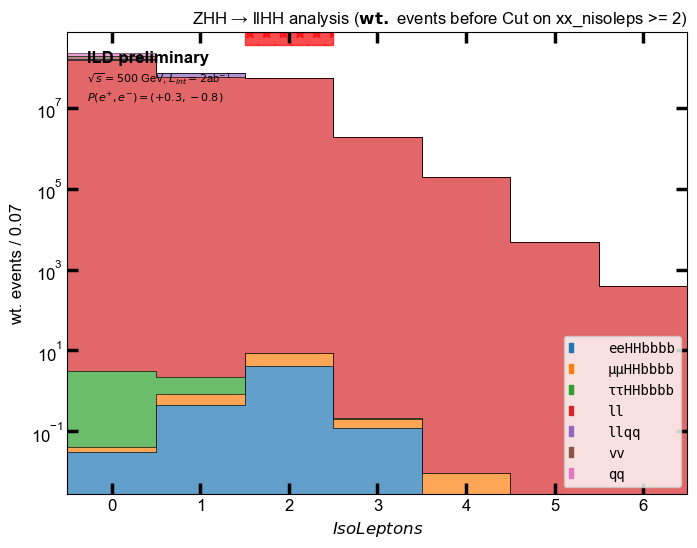

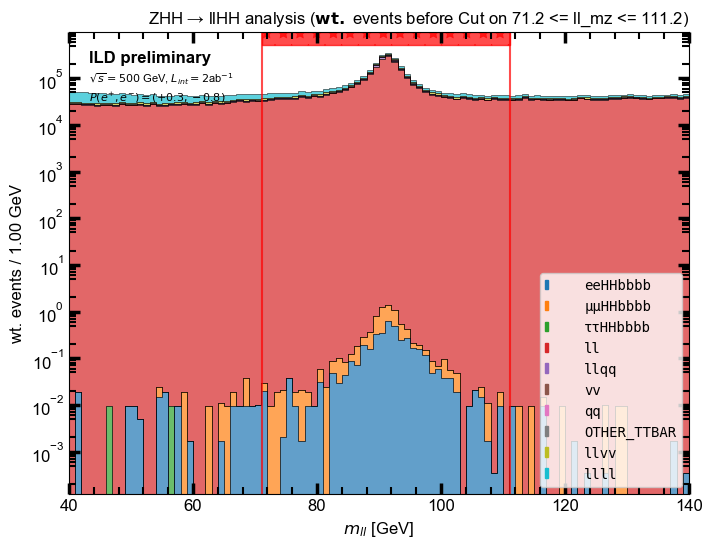

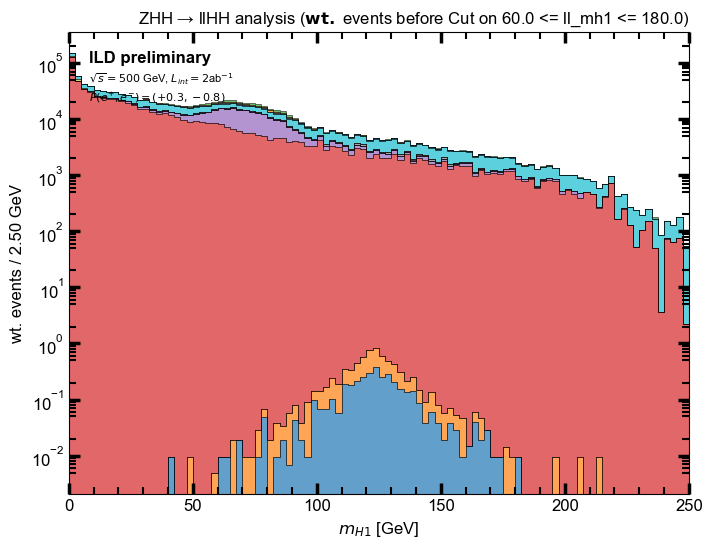

In [29]:
module_reload('phc')
module_reload('zhh')
from matplotlib.ticker import MultipleLocator
from phc import plot_hist, export_figures
from zhh import fig_ild_style, plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, plot_preselection_by_calc_dict, \
    Cut, WindowCut, LessThanEqualCut, GreaterThanEqualCut, EqualCut

subset = presel_results#[:1000000]

plot_options = {
    'llHH': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1) } },
        { 'xlabel': 'm_{ll}', 'xlim': [40, 140], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        None
    ],
    'vvHH': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1) } },
        { 'xlabel': 'bmax3' },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        { 'xlabel': 'E_{vis}' },
        { 'xlabel': 'm_{HH}', 'xunit': 'GeV' },
        None
    ],
    'qqHH': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1) } },
        { 'xlabel': 'bmax4' },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        None
    ]
}

def eval_counts(calc_dict:dict):
    return { key: calc_dict[key][1].sum() for key in calc_dict.keys() }

for hypothesis in list(plot_categories.keys()):
    mask_prev = np.ones(len(subset), dtype='?')
    figs = []
    counts_first = {}
    counts_prev = {}
    
    for i, it in enumerate(apply_cuts(subset, zhh_cuts(hypothesis))):
        mask, cut = it
        
        calc_dics = calc_preselection_by_event_categories(
            subset[mask_prev], processes, weights,
            quantity=cut.quantity,
            order=plot_categories[hypothesis],
            categories_selected=plot_categories[hypothesis],
            categories_additional=categories_additional)
        
        if i == 0:
            counts_first = eval_counts(calc_dics[0])
        
        plot_kwargs = {
            'bins': 100,
            'xlabel': cut.quantity,
            'yscale': yscale_default,
            'plot_flat': False,
            'ild_style_kwargs': {}
        } | plot_options[hypothesis][i]
        plot_kwargs['ild_style_kwargs']['title_postfix'] = ' before ' + cut.__repr__()[1:-1]

        fig = plot_preselection_by_calc_dict(calc_dics[0], hypothesis=hypothesis, **plot_kwargs)[0]
        annotate_cut(fig.axes[0], cut)
        
        figs += [fig]
        
        mask_prev = mask
    
    # Show total efficiency
    counts_last = eval_counts(calc_dics[0])
    figs += [plot_total_efficiency(counts_first, counts_last, hypothesis)]
    
    export_figures(f'{REPO_ROOT}/{prefix}_cuts_{hypothesis}_{suffix}.pdf', figs)

In [209]:
for key, value in calc_dics[0].items():
    print(key, value[0].min(), value[0].max(), value[1].sum())

ττHH 0.65034646 0.8148055 0.046988398
μμHH 0.5268443 0.9107455 10.712792
eeHH 0.5085066 0.8780031 10.123697


B tagging

In [49]:
zhh_cuts('llHH')[0].__repr__()[1:-1]

'Cut on xx_nisoleps >= 2'

In [19]:
mask_1 = np.ones(len(presel_results), dtype='?')
for i, it in enumerate(apply_cuts(presel_results, zhh_cuts('llHH'))):
    if i == 0:
        mask, cut = it
        print(cut)
        mask_2 = mask
        break

<Cut on xx_nisoleps >= 2>


In [ ]:
calc_preselection_by_event_categories(presel_results, )

Table

In [54]:
from phc import module_reload
module_reload('zhh')

from zhh import calc_preselection_by_processes, apply_cuts, zhh_cuts
import numpy as np

from os.path import dirname, basename, splitext
from subprocess import run
from tabulate import tabulate, SEPARATING_LINE

def render_latex(latex:str, location:str):
    latex = latex.replace('_', '\\textunderscore ')
    latex = latex.replace('>=', '$\geq$')
    latex = latex.replace('<=', '$\leq$')
    
    content = "\documentclass[9pt]{article}\n\\usepackage[a4paper,margin=1in,landscape]{geometry}\n\\begin{document}\n " + latex + " \n\\end{document}"

    drn = dirname(location)
    se = splitext(basename(location))

    with open(f'{drn}/{se[0]}.tex', 'w') as f:
        f.write(content)
        
    run(['pdflatex', '-output-directory', drn, f'{drn}/{se[0]}.tex'])

In [14]:
signal_processes = [
    ['e1e1hh', 'e2e2hh', 'e3e3hh'],
    ['n1n1hh', 'n23n23hh'],
    ['qqhh']
]
luminosity_inv_ab = 2
format_cross_section = lambda cross_sec: f'{cross_sec:2E}'
format_expected_events = lambda cross_sec: f'{(cross_sec * luminosity_inv_ab * 1e3):2E}'

tables = []
for j, hypothesis in enumerate(['llHH', 'vvHH', 'qqHH']):
    print(hypothesis)
    
    signal_proc = signal_processes[j]
    background_proc = list(set(np.unique(chunks_f['process'])) - set(signal_proc))

    subset = presel_results

    if True:
        *_, last = apply_cuts(subset, zhh_cuts(hypothesis))
        mask, cat = last
    else:
        mask = subset[f'{hypothesis[:2]}_pass'] == 1

    result = calc_preselection_by_processes(subset[mask], processes, weights,
                                processes_selected=signal_processes[j],
                                processes_additional=6)[0]

    header = []
    rows = []

    cross_sections = []
    expected_events = []

    for process in list(set(result.keys()) - set(signal_proc)):
        header.append(process)
        cross_sec = combined_cross_section(processes, process)
        
        cross_sections.append(format_cross_section(cross_sec))
        expected_events.append(format_expected_events(cross_sec))

    # Background
    bkg_cross_sec = combined_cross_section(processes, background_proc)
    header.append('Background')
    cross_sections.append(format_cross_section(bkg_cross_sec))
    expected_events.append(format_expected_events(bkg_cross_sec))

    # Signal
    sig_cross_sec = combined_cross_section(processes, signal_proc)
    header.append('Signal')
    cross_sections.append(format_cross_section(sig_cross_sec))
    expected_events.append(format_expected_events(sig_cross_sec))

    remaining_rows = []

    final_mask = subset[f'{hypothesis[:2]}_pass'] == 1
    final_label = 'final'

    for i, (mask, cut) in enumerate((*apply_cuts(subset, zhh_cuts(hypothesis)), (
        final_mask, final_label
    ))):
        
        #if cut == final_label:
        #    remaining_rows.append(SEPARATING_LINE)
            
        row = [cut if isinstance(cut, str) else cut.__repr__()[7:][:-1]]
        
        for process in list(set(result.keys()) - set(signal_proc)):
            value = 0.
            for pid in processes['pid'][processes['process'] == process]:
                c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
                value += weights['weight'][subset['pid'][c_mask]].sum()
            
            row.append(value)
        
        # Background
        value = 0.
        for process in background_proc:
            for pid in processes['pid'][processes['process'] == process]:
                c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
                value += weights['weight'][subset['pid'][c_mask]].sum()
                
        row.append(value)
        
        # Signal
        value_before = 0.
        for process in signal_proc:
            for pid in processes['pid'][processes['process'] == process]:
                c_mask = np.array(subset['pid'] == pid, dtype='?')
                value_before += weights['weight'][subset['pid'][c_mask]].sum()
            
        value = 0.
        for process in signal_proc:
            for pid in processes['pid'][processes['process'] == process]:
                c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
                value += weights['weight'][subset['pid'][c_mask]].sum()
                
        if cut == final_label:
            row.append(f"{value:.2f}\neff = {(value/value_before*100):.2f}\%")
        else:
            row.append(value)
            
        remaining_rows.append(row)

    rows = [
        ['$\sigma$ [fb]', *cross_sections],
        ['expected events', *expected_events],
        *remaining_rows
    ]

    print(tabulate(rows, headers=header, tablefmt='simple', numalign='right'))

    latex_out = tabulate(rows, headers=header, tablefmt='latex_raw', numalign='right')
    render_latex(latex_out, f'{REPO_ROOT}/{hypothesis}.pdf')
    
    tables.append((row, header))
    
    print('Rendering done')

llHH


  0%|          | 0/9 [00:00<?, ?it/s]

                           eexyyx    4f_zz_sl    llxyyx    4f_sze_sl    2f_z_bhabhag     4f_sze_l    Background  Signal
-----------------------  --------  ----------  --------  -----------  --------------  -----------  ------------  ------------------
$\sigma$ [fb]             12.2817     366.106   5.10843      1882.54         3375.67      7150.73        205890  2.058380E-02
expected events           24563.5      732212   10216.9  3.76508e+06     6.75133e+06  1.43015e+07    4.1178e+08  4.116760E+01
xx_nisoleps >= 2          11301.8      109268   3225.47       441592     5.54544e+06  3.52026e+06   6.51972e+07  27.297549676150084
71.2 <= ll_mz <= 111.2    3140.58     75882.7   2119.19      99908.1          402522       302248   3.52985e+06  23.812009709421545
85.0 <= ll_mh1 <= 165.0   1901.52     12260.2   1257.01      17123.8         27377.7      48771.6        172524  21.195741715375334
85.0 <= ll_mh2 <= 165.0   1092.64      745.65   710.402      1461.89          605.82      1463.52   

  0%|          | 0/8 [00:00<?, ?it/s]

                               yyvlyx      4f_ww_h    yyxylv    4f_zzorww_h     4f_ww_sl       2f_z_h    Background  Signal
---------------------------  --------  -----------  --------  -------------  -----------  -----------  ------------  ------------------
$\sigma$ [fb]                 138.617      4494.38   138.395        3746.82      5571.64      19625.1        205890  4.487743E-02
expected events                277234  8.98875e+06    276789    7.49364e+06  1.11433e+07  3.92501e+07    4.1178e+08  8.975486E+01
xx_nisoleps=0                  122939  8.86366e+06    122485    7.38899e+06  4.86996e+06  3.85134e+07   2.64468e+08  70.56341475248337
85.0 <= vv_mh1 <= 165.0         78363  3.80818e+06   78203.2    3.17704e+06  1.14178e+06  1.12285e+07   4.43165e+07  54.933465242385864
85.0 <= vv_mh2 <= 165.0       59508.8  1.46469e+06   59467.2     1.3882e+06       212438  2.71705e+06   7.83905e+06  44.337955206632614
60.0 <= vv_mh1 <= 180.0       59508.8  1.46469e+06   59467.2     1.3882e+

  0%|          | 0/7 [00:00<?, ?it/s]

                           4f_zz_h    yyvlyx    yyuyyc    yycyyc    yycyyu       2f_z_h    Background  Signal
-----------------------  ---------  --------  --------  --------  --------  -----------  ------------  ------------------
$\sigma$ [fb]              407.447   138.617   98.4521    97.665    99.046      19625.1        205890  1.370414E-01
expected events             814894    277234    196904    195330    198092  3.92501e+07    4.1178e+08  2.740828E+02
xx_nisoleps=0               801004    122939    193677    192356    194698  3.85134e+07   2.64468e+08  217.07889699935913
60.0 <= qq_mh1 <= 180.0      37144   12989.3   8248.14   33959.3   8329.91       257608        446968  85.96207475662231
60.0 <= qq_mh2 <= 180.0    31008.7   12207.6   7690.66   31071.9   7785.56      78551.8        212622  81.17104601860046
xx_pt_miss <= 70.0         30874.4   6542.62   7671.47   30969.9   7765.36        77442        195766  79.14628791809082
xx_thrust <= 0.9           9155.02   6463.84   7657

In [ ]:
for process in signal_proc:
    for pid in processes['pid'][processes['process'] == process]:
        c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
        value += weights['weight'][subset['pid'][c_mask]].sum()

In [175]:
for process in list(set(result.keys()) - set(signal_proc)):
    value = 0.
    for pid in processes['pid'][processes['process'] == process]:
        c_mask = np.array(subset['pid'] == pid, dtype='?') & mask
        value += weights['weight'][subset['pid'][c_mask]].sum()
        
    print(process, value)

yyvelv 0.0
4f_sze_sl 1085.3364181518555
2f_z_bhabhang 72.26543426513672
2f_z_bhabhag 447.90260124206543
4f_sze_l 723.5318717956543
yyvlev 0.0


In [123]:
len(header), len(cross_sections)

(8, 8)

In [122]:
rows

[]

In [118]:
columns

[[12.281731501817704, '2.456346E+04'],
 [1882.5403021240236, '3.765081E+06'],
 [3375.6655407714843, '6.751331E+06'],
 [7150.728549804688, '1.430146E+07'],
 [366.10612426757814, '7.322122E+05'],
 [5.108425629660488, '1.021685E+04'],
 [205890.0673396234, '4.117801E+08'],
 [0.02058380217640661, '4.116760E+01']]

# Generator Level Cuts

The goal is to find equal cuts to generate 2f and 4f in a phase space region that cannot be eliminated through simple cuts

In [111]:
processes_2f = np.unique(processes['process'][np.char.find(processes['process'], '2f') == 0])
processes_4f = np.unique(processes['process'][np.char.find(processes['process'], '4f') == 0])

In [ ]:
presel_results['vv_mhh']

In [82]:
import scipy

def make_lambda(presel_results, hypothesis):
    sig_0 = 0
    bkg = 0
    
    return sig/bkg

scipy.optimize.minimize_scalar(make_lambda(presel_results), bounds=(0, 1.000000000001), method='bounded')

TypeError: make_lambda() missing 1 required positional argument: 'hypothesis'

In [85]:
scipy.optimize.minimize_scalar(lambda x: -x, bounds=(0, 1.0000000001), method='bounded',)

 message: Solution found.
 success: True
  status: 0
     fun: -0.9999940392390129
       x: 0.9999940392390129
     nit: 25
    nfev: 25

In [107]:
xlim=(0, 650.)

calc_dict = calc_preselection_by_event_categories(presel_results, processes, weights, category_map_inv, 'llHH', 'll_mz',
                                                  event_categories=[11, 16, 12, 13, 14], additional_event_categories=27)[0]

categories = np.array(list(calc_dict.keys()))
counts = np.zeros(len(categories), dtype=float)

for i, cat in enumerate(categories):
    counts[i] = calc_dict[cat][1].sum()
    
mask = np.argsort(-counts)
categories = categories[mask]
counts = counts[mask]

  0%|          | 0/32 [00:00<?, ?it/s]

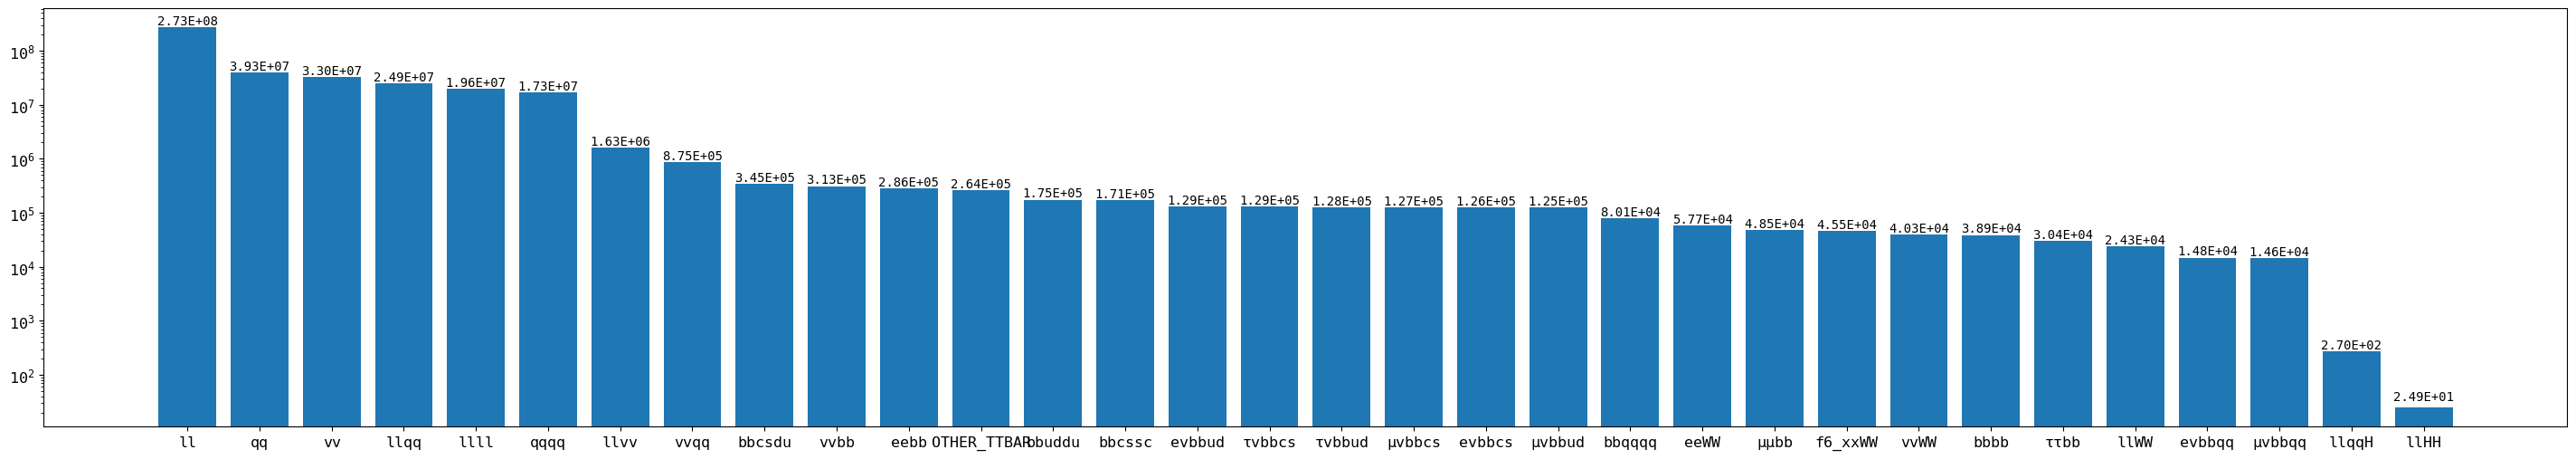

In [108]:
fig, ax = plt.subplots(figsize=(36, 6))

ax.bar(categories, counts)
ax.set_yscale('log')
rects = ax.patches

for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{count:.2E}', ha="center", va="bottom"
    )

plt.show()

In [117]:
module_reload('zhh')
from zhh import get_final_state_counts, final_state_stack

#fsc = get_final_state_counts(f'{REPO_ROOT}/PreselectionFinal/v1', [0,1], chunks_f)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fsc

In [119]:
fsc.nbytes

179125

In [70]:
def test(i):
    return np.sum(presel_results['ll_mh1'][presel_results['pid'] == i])

%timeit for i in range(len(processes)): test(i)

17.7 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


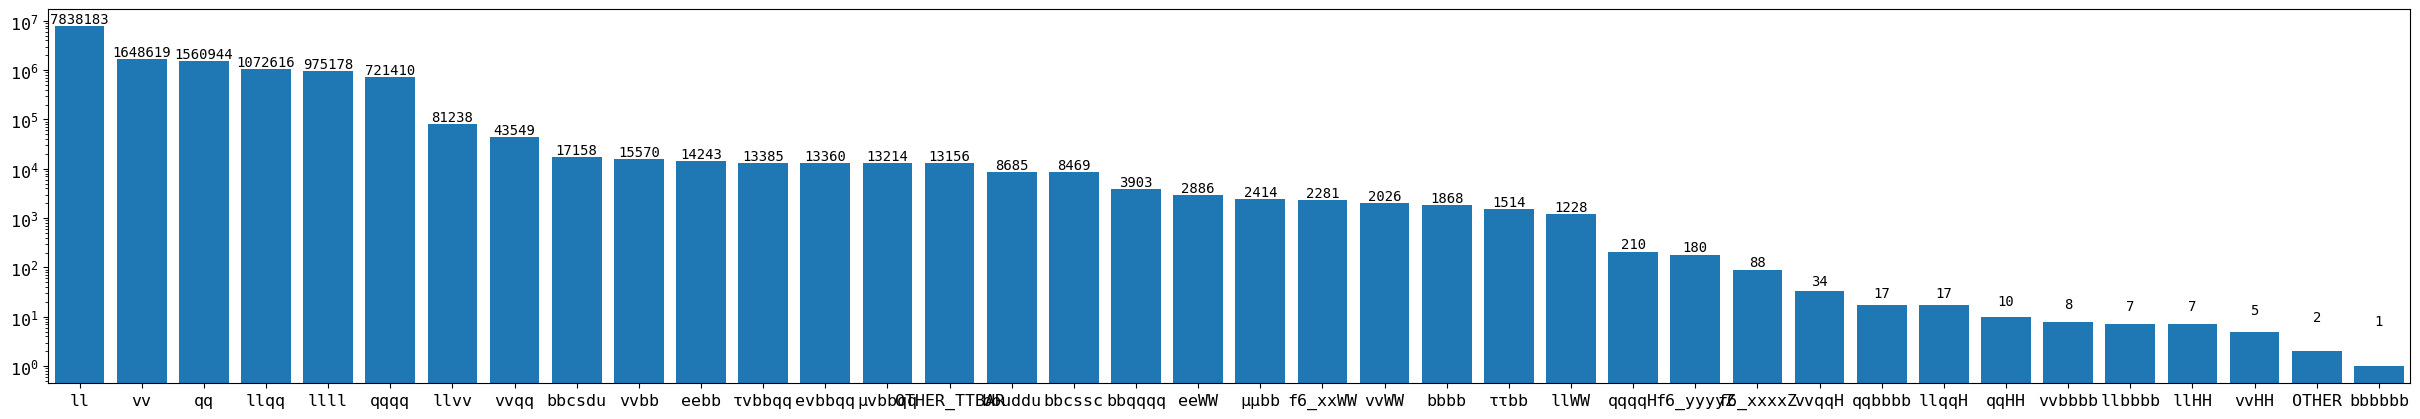

In [25]:
unq_cat, unq_counts = np.unique(presel_results['event_category'], return_counts=True)
mask = np.argsort(-unq_counts)

unq_cat = unq_cat[mask]
unq_counts = unq_counts[mask]
cat_counts = dict(zip(unq_cat, unq_counts))
unq_labels = category_arr['name'][np.isin(category_arr['evt_cat'], unq_cat)][mask]

fig, ax = plt.subplots(figsize=(24, 4))

ax.bar(unq_labels, unq_counts)
for rect, label in zip(ax.patches, unq_counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
ax.set_yscale('log')
ax.set_xlim(-0.5, len(unq_labels)-.5)
fig.set_tight_layout({"pad": .0})

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

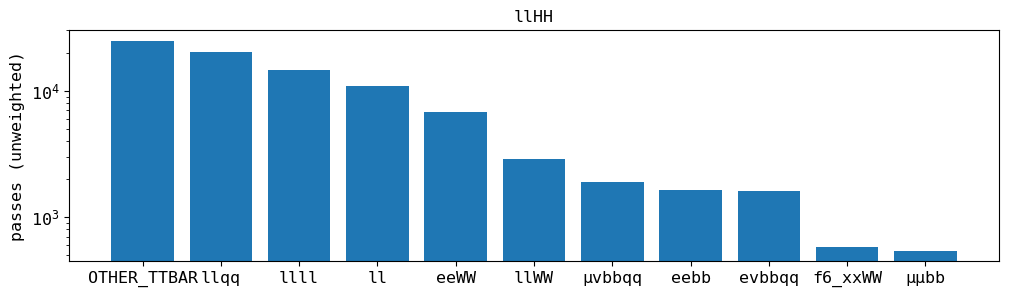

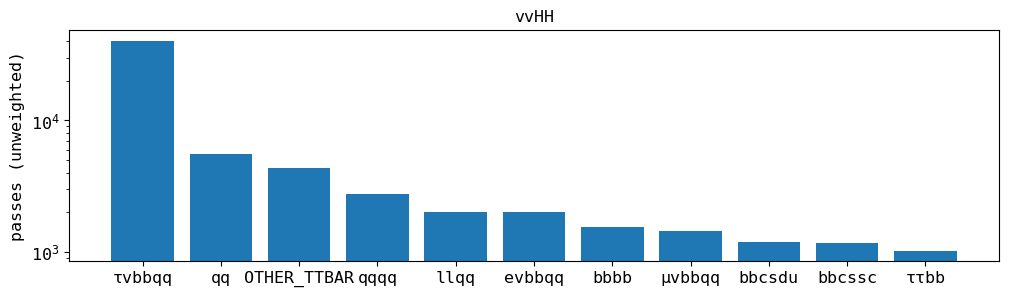

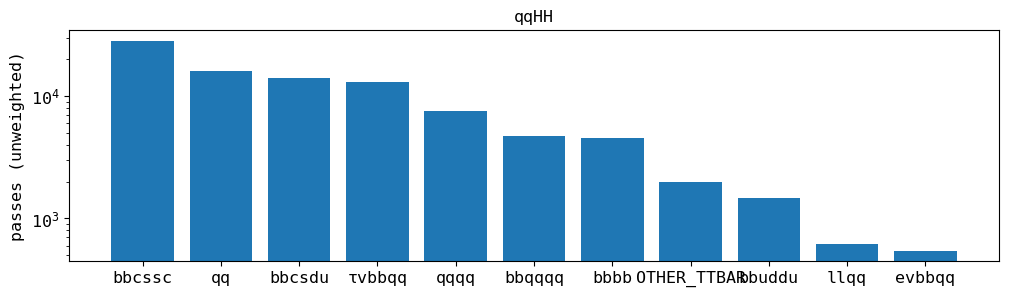

In [26]:
#event_categories = event_categories[event_categories != 0]
per_cat = {}

for presel in ['ll', 'vv', 'qq']:
    dtype = [
        ('category', 'i'),
        ('passes', 'f')
    ]
    passes_per_cat = np.zeros(len(unq_cat), dtype=dtype)
    passes_per_cat['category'] = unq_cat
    
    i = 0
    for category in tqdm(unq_cat):
        passes_per_cat[i]['category'] = category
        events = presel_results[presel_results['event_category'] == category]
        
        res = 0.
        for pid in np.unique(events['pid']):
            subset = events[events['pid'] == pid]
            res += np.sum(subset[f'{presel}_pass'] == 1) * weights['weight'][weights['pid'] == pid][0]
        
        passes_per_cat[i]['passes'] = res #/ cat_counts[category]
        
        i += 1
            
    per_cat[presel] = passes_per_cat
        
    sorted = passes_per_cat[np.argsort(-passes_per_cat['passes'])][:11]
    categories = []
    for s in sorted:
        categories.append(category_map_inv[s['category']])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(categories, sorted['passes'])
    ax.set_title(f'{presel}HH')
    ax.set_yscale('log')
    ax.set_ylabel('passes (unweighted)')